## Packages

In [2]:
from scipy.integrate import odeint, quad
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt
import waterproperties as water

## Reaction and Background

This will be simulating the product of Acetic Anhydride. The a possible reaction mechanism is shown as follows:

In a PFR:
$$\text{Acetone} \rightarrow \text{Ketene} + \text{Methane}$$
$$\text{Ketene} \rightarrow \text{Carbon Monoxide} + \text{Ethylene}$$

In a CSTR:
$$\text{Ketene} + \text{Acetic Acid} \rightarrow \text{Acetic Anhydride}$$

The following is in chemical formulas:

In a PFR:
$$C_3 H_6O \rightarrow C_2H_2O + CH_4$$
$$C_2 H_2O \rightarrow CO + \frac{1}{2} C_2H_4$$

In a CSTR:
$$C_2 H_2O + C_2H_4O_2 \rightarrow C_4H_6O_3$$


And these are the apprevations that will be used:
$$A \rightarrow B + C$$
$$B \rightarrow D + \frac{1}{2}E$$

$$B + F \rightarrow G$$

There are 3 main by-products in this reaction; Methane, Carbon Monoxide, and Ethylene. 
The trick here is to get as much Ketene as possible in the first reaction but not produce a lot of $CO$ and $C_2H_4$
This will allow us to maximize the outlet concentration of Acetic Anhydride

The two feeds are Acetone and Acetic Acid.

<img src='PFD3.png'>

## Physics Base Model

In [136]:
def CSTR(y, t, F0, Ta_0, v̇, Vr1, Vr2, Q1, Q2):
    Ca1, Cb1, Cc1, Cd1, Ce1, T1, Ca2, Cb2, Cc2, Cd2, Ce2, T2  = y
    
    
    Fa0, Fb0, Fc0, Fd0, Fe0  = F0
    
    Fa1, Fb1, Fc1, Fd1, Fe1  = Ca1*v̇, Cb1*v̇, Cc1*v̇, Cd1*v̇, Ce1*v̇
    Na1, Nb1, Nc1, Nd1, Ne1  = Ca1*Vr1, Cb1*Vr1, Cc1*Vr1, Cd1*Vr1, Ce1*Vr1
    
    Fa2, Fb2, Fc2, Fd2, Fe2  = Ca2*v̇, Cb2*v̇, Cc2*v̇, Cd2*v̇, Ce2*v̇
    Na2, Nb2, Nc2, Nd2, Ne2  = Ca2*Vr2, Cb2*Vr2, Cc2*Vr2, Cd2*Vr2, Ce2*Vr2
     
    
    def Cps(T, A, B, C, D, E, F, G):
        return A + B*(((C/T)**2*np.exp(C/T))/(np.exp(C/T) -1)**2) + D*(((E/T)**2*np.exp(E/T))/(np.exp(E/T) -1)**2) + F*(((G/T)**2*np.exp(G/T))/(np.exp(G/T) -1)**2)
    
    def Cp(T, A, B, C, D, E):
        return A + B*(C/T/(np.sinh(C/T)))**2 + D*(E/T/(np.cosh(E/T)))**2
    
    coeff_a = [33258, 31740, 309.1, 76072, 1374.7, 78900, 3334.7]
    coeff_b = [36940, 68650, 1490, 45240, 640]
    coeff_c = [33298, 79933, 2086.9, 41602, 991.96]
    coeff_d = [29108, 8773, 3085.1, 8455.3, 1538.2]
    coeff_e = [33380, 94790, 1596, 55100, 740.8]
    
    Cpa = lambda T: Cps(T, *coeff_a)
    Cpb = lambda T: Cp(T, *coeff_b)
    Cpc = lambda T: Cp(T, *coeff_c)
    Cpd = lambda T: Cp(T, *coeff_d)
    Cpe = lambda T: Cp(T, *coeff_e)
 
    #---- Kinetics ----#
    
    def k(A, Ea, T):
        R = 8.314 # J/mole-K
        return A*np.exp(-Ea/(R*T))
    
    A_1 = 8.2e14
    Ea_1 = 2.845e5 # J/mol
    k_1_1 = k(A_1, Ea_1, T1)
    k_1_2= k(A_1, Ea_1, T2)
    
    A_2 = 1.7e17
    Ea_2 = 3.259e5 # J/mol
    k_2_1 = k(A_2, Ea_2, T1)
    k_2_2 = k(A_2, Ea_2, T2)
    
    ra_1 = k_1_1*Ca1
    ra_2 = k_1_2*Ca2
    
    rb_1 = k_2_1*Cb1
    rb_2 = k_2_2*Cb2
    
    
    
    #---- Thermodynamics ----#
    
    Hr_a = -2.4700e5 # kJ/kmol
    Hr_b = -47500
    Hr_c = -74520
    Hr_d = -1.1053e5
    Hr_e = 52510
    
    ΔHr_1 = lambda T: (Hr_c + Hr_b - Hr_a) + quad(lambda T: Cp(T, *coeff_c) + Cp(T, *coeff_b)\
                                                 -Cps(T, *coeff_a), 298.15, T)[0]
    ΔHr_2 = lambda T:(.5*Hr_e + Hr_d - Hr_b) + quad(lambda T: .5*Cp(T, *coeff_e) + Cp(T, *coeff_d)\
                                                 -Cp(T, *coeff_b), 298.15, T)[0]
    
    #---- Equations ----#
    
    
    
    dCa1dt = (Fa0 - Fa1)/Vr1 - ra_1
    dCb1dt = (Fb0 - Fb1)/Vr1 + ra_1 - rb_1
    dCc1dt = (Fc0 - Fc1)/Vr1 + ra_1
    dCd1dt = (Fd0 - Fd1)/Vr1 + rb_1
    dCe1dt = (Fe0 - Fe1)/Vr1 + .5*rb_1
    
    dT1dt = (Q1 - Fa0*Cpa(T1)*(T1 - Ta_0) - ra_1*ΔHr_1(T1) - rb_1*ΔHr_2(T1))/\
            (Na1*Cpa(T1) + Nb1*Cpb(T1) + Nc1*Cpc(T1) + Nd1*Cpd(T1) + Ne1*Cpe(T1))
    
    dCa2dt = (Fa1 - Fa2)/Vr2 - ra_2
    dCb2dt = (Fb1 - Fb2)/Vr2 + ra_2 - rb_2
    dCc2dt = (Fc1 - Fc2)/Vr2 + ra_2
    dCd2dt = (Fd1 - Fd2)/Vr2 + rb_2
    dCe2dt = (Fe1 - Fe2)/Vr2 + .5*rb_2
    
    dT2dt = (Q2 - Fa1*Cpa(T2)*(T2 - T1) - Fb1*Cpb(T2)*(T2 - T1) - Fc1*Cpc(T2)*(T2 - T1) - Fd1*Cpd(T2)*(T2 - T1) - Fe1*Cpe(T2)*(T2 - T1) - ra_2*ΔHr_1(T2) - rb_2*ΔHr_2(T2))/\
            (Na2*Cpa(T2) + Nb2*Cpb(T2) + Nc2*Cpc(T2) + Nd2*Cpd(T2) + Ne2*Cpe(T2))
    
    
    equations = np.array([dCa1dt, dCb1dt, dCc1dt, dCd1dt, dCe1dt, dT1dt, dCa2dt, dCb2dt, dCc2dt, dCd2dt, dCe2dt, dT2dt])
    
    
    return equations

## Simulation

Goal is to maximize Ketene and minimize Methane, Carbon Monoxide, and Ethylene


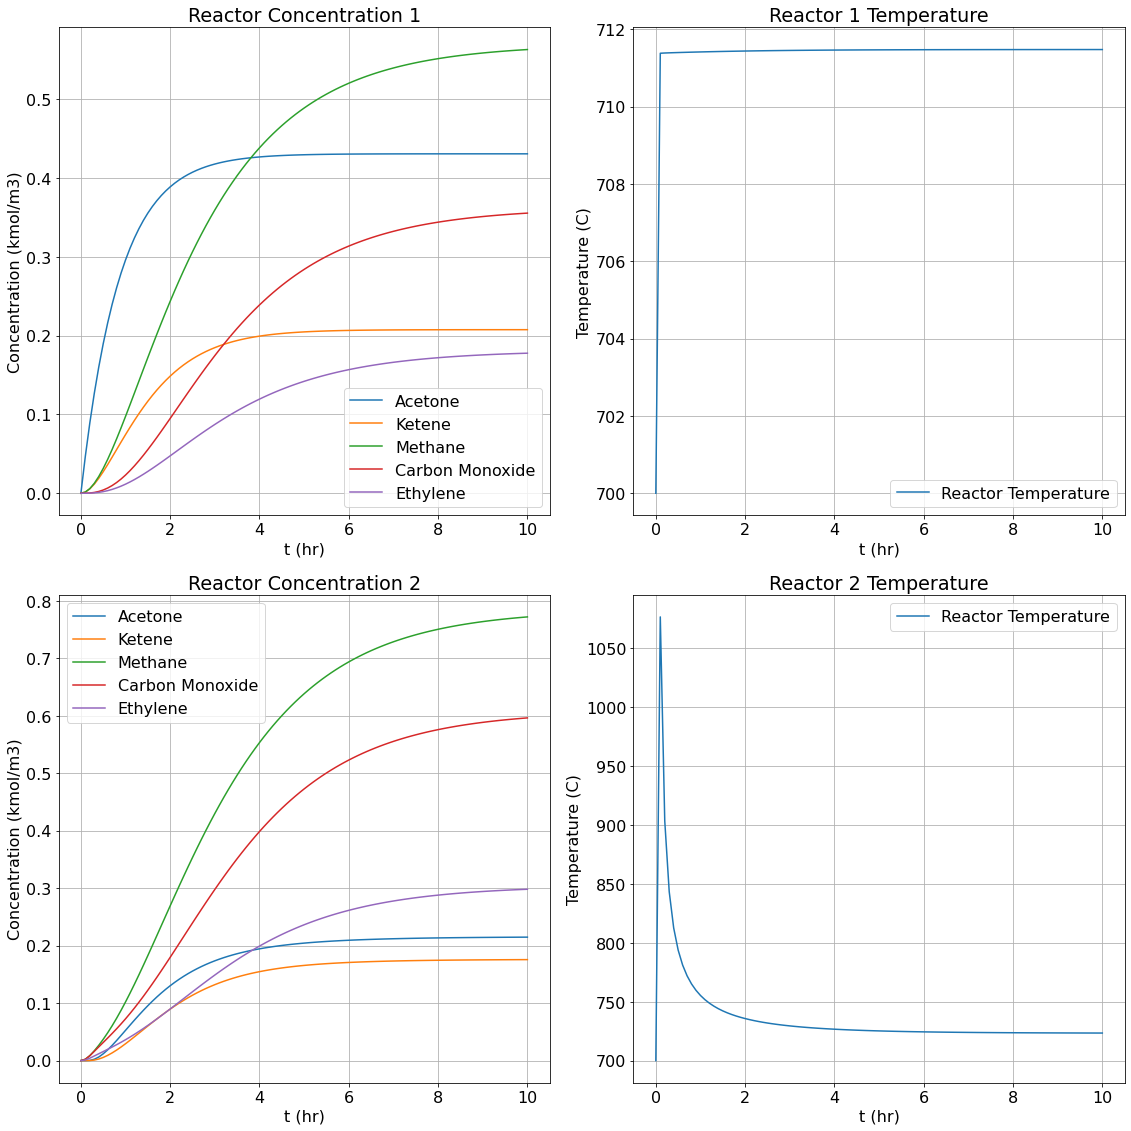

In [140]:
# Parameters
Fa0 = 50 # kmol/hr
Ta_0 = 700 + 273.15
Vr1 = 100 # m3
Vr2 = 50 # m3
v̇ = 50 # m3/hr
Q1 = 9.24e7 # kJ/hr
Q2 = 9.24e7 # kJ/hr

Ca0 = Fa0/v̇
Cb0 = 0
Cc0 = 0
Cd0 = 0
Ce0 = 0

F0 = [Fa0, Cb0*v̇, Cc0*v̇, Cd0*v̇, Ce0*v̇]

initials = [1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 700+273.15, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 700+273.15]
t = np.linspace(0, 10, 101)

Ca1, Cb1, Cc1, Cd1, Ce1, T1, Ca2, Cb2, Cc2, Cd2, Ce2, T2 = odeint(CSTR, initials, t, args=(F0, Ta_0, v̇, Vr1, Vr2, Q1, Q2)).T

plotsize=(16,16)
fontsize=16
print('Goal is to maximize Ketene and minimize Methane, Carbon Monoxide, and Ethylene')

plt.figure(1, figsize=plotsize)
plt.rc('font', size=fontsize)

plt.subplot(2,2,1)
plt.plot(t, Ca1, label='Acetone')
plt.plot(t, Cb1, label='Ketene')
plt.plot(t, Cc1, label='Methane')
plt.plot(t, Cd1, label='Carbon Monoxide')
plt.plot(t, Ce1, label='Ethylene')
plt.ylabel('Concentration (kmol/m3)')
plt.title('Reactor Concentration 1')
plt.xlabel('t (hr)')
plt.legend(loc='best')
plt.grid()

         
plt.subplot(2,2,2)
plt.plot(t,T1-273.15, label='Reactor Temperature')
plt.xlabel('t (hr)')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')
plt.title('Reactor 1 Temperature')
plt.grid()


plt.subplot(2,2,3)
plt.plot(t, Ca2, label='Acetone')
plt.plot(t, Cb2, label='Ketene')
plt.plot(t, Cc2, label='Methane')
plt.plot(t, Cd2, label='Carbon Monoxide')
plt.plot(t, Ce2, label='Ethylene')
plt.ylabel('Concentration (kmol/m3)')
plt.title('Reactor Concentration 2')
plt.xlabel('t (hr)')
plt.legend(loc='best')
plt.grid()

         
plt.subplot(2,2,4)
plt.plot(t,T2-273.15, label='Reactor Temperature')
plt.xlabel('t (hr)')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')
plt.title('Reactor 2 Temperature')
plt.grid()

plt.tight_layout()
plt.show()

In [26]:
m = GEKKO()